In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.colorbar
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts
from sklearn.linear_model import ElasticNet

consts = getConsts()

sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.5, style='white')

In [2]:
sampleToPatientID = lambda x: '-'.join(x.split('-')[:3])

In [3]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [4]:
dataset_list = ['TCGA', 'Ringner']
beta_values_FULL_balanced_CpGs = {}
clinical = {}

In [5]:
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')

In [6]:
clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv'), index_col=0)
clinical['Ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})

In [7]:
# for dataset in ['TCGA', 'Ringner']:
#     beta_values_FULL_balanced_CpGs[dataset] = consts['project_data_func_dict'][dataset]['balanced']()

In [8]:
## IGNORE

# beta_values_FULL_balanced_CpGs_NONANS = beta_values_FULL_balanced_CpGs.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
# beta_values_FULL_balanced_CpGs_NONANS.to_csv(os.path.join(proj_dir, 'beta_values_FULL_balanced_CpGs_NONANS.txt'), sep='\t')

In [9]:
beta_peak_indir = '/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/MolClock_Paper_1/1. Analytic Datasets/Beta Peak Decomposition'

In [10]:
## IGNORE
# no_na_tumors = np.loadtxt(os.path.join(os.path.join(beta_peak_indir, 'Ringner',
#                                        'readable_tables',
#                                        'no_na_tumors.txt'), dtype=str)
# ductal_samples = clinical['Ringner'].index[clinical['Ringner']['ductal']]
# print(np.intersect1d(ductal_samples, no_na_tumors).shape)
# print(no_na_tumors.shape)

In [11]:
# # init_hypometh_sites = 
# # init_hypermeth_sites = 

# # randomly selected sites - just to work out the rest of the code
# init_hypometh_sites = pd.Series(dict(zip(clinical.index, [np.random.choice(beta_values_FULL_balanced_CpGs.index,
#                                         size=np.random.randint(20, 40, 1)[0],
#                                         replace=False
#                                        ) for i in range(clinical.shape[0])])))
# init_hypermeth_sites = pd.Series(dict(zip(clinical.index, [np.random.choice(beta_values_FULL_balanced_CpGs.index,
#                                         size=np.random.randint(20, 40, 1)[0],
#                                         replace=False
#                                        ) for i in range(clinical.shape[0])])))

In [12]:
# clinical['beta_A'] = beta_values_FULL_balanced_CpGs.apply(lambda col:col[init_hypometh_sites[col.name]].mean(), 0)
# clinical['beta_B'] = beta_values_FULL_balanced_CpGs.apply(lambda col:col[init_hypermeth_sites[col.name]].mean(), 0)

In [13]:
for dataset in dataset_list:
    print(dataset)
    modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             dataset,
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
    alpha = pd.read_csv(os.path.join(beta_peak_indir,
                                             dataset,
                                           'readable_tables',
                                           'alpha.txt'), sep=' ')
    delta = pd.read_csv(os.path.join(beta_peak_indir,
                                             dataset,
                                           'readable_tables',
                                           'delta.txt'), sep=' ')
#     display(modes)
#     display(alpha)
#     display(delta)
    
    if dataset == 'TCGA':
        modes = modes.rename(index=sampleToPatientID)
    
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    clinical[dataset]['mitotic_age_estA'] = -np.log(1 - 2*clinical[dataset]['beta_A']) / 2
    clinical[dataset]['mitotic_age_estB'] = -np.log(2*clinical[dataset]['beta_B'] - 1) / 2
    clinical[dataset]['mitotic_age'] = (clinical[dataset]['mitotic_age_estA'] + clinical[dataset]['mitotic_age_estB']) / 2
#     clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['mitotic_age'] / clinical[dataset]['alpha']

TCGA
Ringner


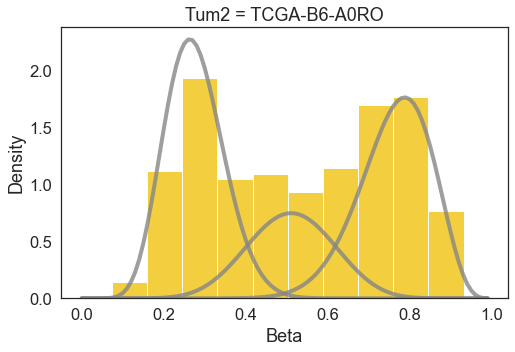

In [14]:
from scipy.stats import beta

fig, ax = plt.subplots(figsize=(8, 5))

samp = 'TCGA-B6-A0RO'
beta_values_balancedSites_TCGA = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.methyl.balancedSites.tsv'),
                      index_col=0).rename(columns=sampleToPatientID)

sns.histplot(ax=ax, x=beta_values_balancedSites_TCGA[samp], color=consts['palette_jco'][1], stat='density')
ax.set_title(f'Tum2 = {samp}')
ax.set_xlabel('Beta')

# delete this
i = 0
frac_list = [0.41, 0.2, 0.39]

for model in ['V1', 'V2', 'V3']:
    alpha = pd.read_table(os.path.join(beta_peak_indir,
                                             'TCGA',
                                           'readable_tables',
                                           'alpha.txt'), sep=' ').rename(index=sampleToPatientID)
    delta = pd.read_table(os.path.join(beta_peak_indir,
                                             'TCGA',
                                           'readable_tables',
                                           'delta.txt'), sep=' ').rename(index=sampleToPatientID)
    a = alpha.loc[samp, model]
    d = delta.loc[samp, model]

    x = np.linspace(0, 0.99, 100)
    ax.plot(x, beta.pdf(x, a, d) * frac_list[i],
            lw=4, alpha=0.8, color=consts['palette_jco'][2])
    
    # delete this
    i += 1

fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/3265866721.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(ax=ax, data=df_combined, y = 'Mitotic Age', x = 'Dataset', hue = 'Dataset', legend=False, palette=consts['palette_jco'])


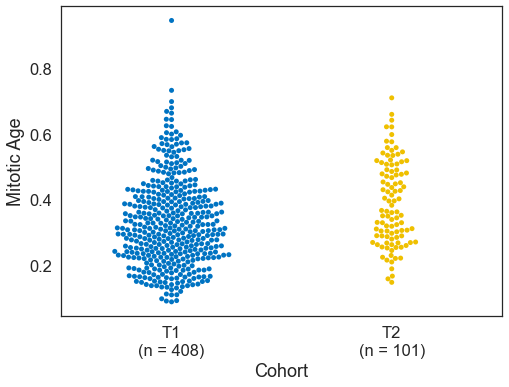

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
text_fontsize = 18
fig.tight_layout(pad=1)

df_ch1 = pd.DataFrame({'Mitotic Age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'mitotic_age'].dropna(), 'Dataset':'T1'})
df_ch2 = pd.DataFrame({'Mitotic Age':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'mitotic_age'].dropna(), 'Dataset':'T2'})
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

sns.swarmplot(ax=ax, data=df_combined, y = 'Mitotic Age', x = 'Dataset', hue = 'Dataset', legend=False, palette=consts['palette_jco'])
ax.set_xlabel('Cohort')

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["Dataset"] == group).sum()})' for group in ['T1', 'T2']])
# patches = [
#     mpatches.Patch(color=consts['palette_jco'][0], label='Cohort T1'),
#     mpatches.Patch(color=consts['palette_jco'][1], label='Cohort T2')
# ]

# plots_botLeft, plots_topRight = ax.get_position().get_points()
# center_x = (plots_botLeft[0] + plots_topRight[0])/2
# center_y = (plots_botLeft[1] + plots_topRight[1])*2/3

# fig.legend(
#     handles=patches,
#     title='Dataset',
#     loc='center', bbox_to_anchor=(center_x, center_y))

fig.savefig(os.path.join(figure_outdir, 'mitotic_age.pdf'), format='pdf', pad_inches=0.1)

In [16]:
predictors = ['Stroma', 'Lipid', 'IR', 'Mitotic Checkpoint', 'Mitotic Progression', 'Basal', 'Early Response', 'SR',
# 'FGA_Gain', 'FGA_Loss',
              'FGA',
              'LUMP'
             ]
response = 'spfPercent'

train_data = clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], predictors + [response]].dropna()
train_X = train_data[predictors]
train_y = train_data[response]

In [17]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
def myScoreFunc(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
#     return r2
#     n_pos = np.sum(y_pred > 0)
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
#     return r2 + pct_pos * 5
    return r2 + 10 * np.all(model.predict(TCGA_X) > 0)

# eNetCV = ElasticNetCV(alphas=np.linspace(0.01, 0.99, 10), l1_ratio=np.linspace(0.01, 0.99, 10))
eNetCV = GridSearchCV(ElasticNet(), param_grid={'alpha':np.linspace(0.1, 3, 10), 'l1_ratio':np.linspace(0.01, 0.99, 10)},
                     scoring=myScoreFunc)
eNetCV.fit(train_X, train_y)

print(eNetCV.score(train_X, train_y))
print(eNetCV.best_score_)
print(eNetCV.best_params_)
# eNetCV.best_estimator_.coef_

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_22121/355702037.py", line 10, in myScoreFunc
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
NameError: name 'TCGA_X' is not defined

  warnings.warn(
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

NameError: name 'TCGA_X' is not defined

In [ ]:
plt.scatter(eNetCV.predict(train_X), train_y)

Ttest_indResult(statistic=1.7117043905385119, pvalue=0.08760529139259099)


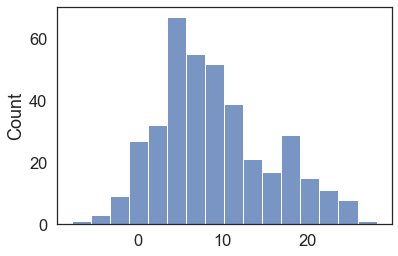

In [18]:
TCGA_X = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], predictors].dropna()
TCGA_y_pred = eNetCV.predict(TCGA_X)

sns.histplot(TCGA_y_pred)
from scipy.stats import ttest_ind
print(ttest_ind(train_y, TCGA_y_pred))

<Axes: xlabel='spfPercent', ylabel='Count'>

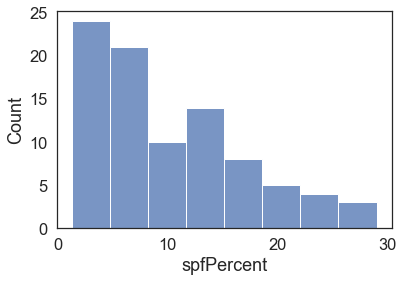

In [19]:
sns.histplot(train_y)

In [20]:
clinical['TCGA'].loc[TCGA_X.index, 'spfPercent'] = TCGA_y_pred

In [21]:
# Growth rate with 1 day as time unit
for dataset in dataset_list:
    clinical[dataset]['growth_rate'] = clinical[dataset]['spfPercent'] / 3
    clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['mitotic_age'] / clinical[dataset]['growth_rate']

<Axes: xlabel='growth_rate', ylabel='Count'>

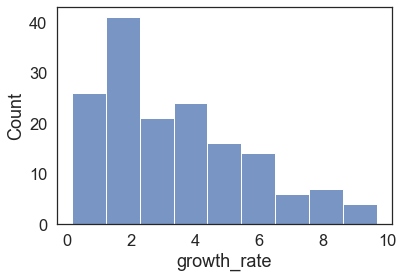

In [22]:
sns.histplot(clinical['Ringner']['growth_rate'])

In [206]:
## Flip rate

flip_rate_TCGA = clinical['TCGA']['calendar_age_prod_flip_rate'].median() / 3
flip_rate_Ringner = clinical['Ringner']['calendar_age_prod_flip_rate'].median() / 3

print(f'Cohort T1-predicted flip rate: {flip_rate_TCGA}')
print(f'Cohort T2-predicted flip rate: {flip_rate_Ringner}')

Cohort T1-predicted flip rate: 0.03553742223833058
Cohort T2-predicted flip rate: 0.043564521122914014


In [212]:
n_samps_TCGA = clinical['TCGA']['in_analysis_dataset'].sum()
n_samps_Ringner = clinical['Ringner']['in_analysis_dataset'].sum()
flip_rate_est = (flip_rate_TCGA * n_samps_TCGA + flip_rate_Ringner * n_samps_Ringner) / (n_samps_TCGA + n_samps_Ringner)

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_7616/72006105.py:36: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(ax=ax, data=df_combined, y='Calendar Age', x='Dataset',


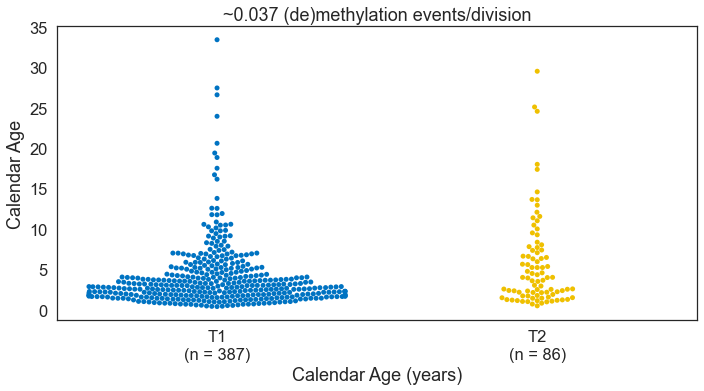

In [249]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
text_fontsize = 18
fig.tight_layout(pad=1)


clinical['TCGA']['calendar_age'] = clinical['TCGA']['calendar_age_prod_flip_rate'] / flip_rate_est
clinical['Ringner']['calendar_age'] = clinical['Ringner']['calendar_age_prod_flip_rate'] / flip_rate_est


df_ch1 = pd.DataFrame({'Calendar Age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'calendar_age'],
                       'Size':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'T Stage'],
                       'Dataset':'T1'}).dropna()
df_ch2 = pd.DataFrame({'Calendar Age':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'calendar_age'],
                       'Size':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'size'],
                       'Dataset':'T2'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)
# df_combined = df_ch2


#####
'''
#Create a matplotlib colormap from the sns seagreen color palette
cmap = sns.light_palette("seagreen", reverse=False, as_cmap=True )
# Normalize to the range of possible values from df["c"]
norm = matplotlib.colors.Normalize(vmin=df_combined["Size"].min(), vmax=df_combined["Size"].max())
# create a color dictionary (value in c : color from colormap) 
colors = {}
for cval in df_combined["Size"]:
    colors.update({cval : cmap(norm(cval))})
    '''
#####

sns.swarmplot(ax=ax, data=df_combined, y='Calendar Age', x='Dataset',
              hue='Dataset', palette=consts['palette_jco'],
              legend=False,
#               palette=colors
             )
ax.set_title(f'~{flip_rate_est:.3f} (de)methylation events/division')
ax.set_xlabel('Cohort')
ax.set_xlabel('Calendar Age (years)')

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["Dataset"] == group).sum()})'
                   for group in df_combined['Dataset'].unique()])


'''
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Size (mm)')
'''


fig.savefig(os.path.join(figure_outdir, 'calendar_age.pdf'), format='pdf', pad_inches=0.1)

In [232]:
m_util.pearsonCorrelation(df_ch2['Calendar Age'], df_ch2['Size'])

LinregressResult(slope=-0.9561700251511219, intercept=31.139221514803662, rvalue=-0.3784717216582971, pvalue=0.0003267970813558531, stderr=0.25514756221482693, intercept_stderr=2.0515927836963814)

In [233]:
df_ch1.groupby('Size')['Calendar Age'].mean()

Size
T1    5.021818
T2    3.804174
T3    2.578735
T4    3.347601
TX    1.455012
Name: Calendar Age, dtype: float64

<Axes: xlabel='V2', ylabel='Count'>

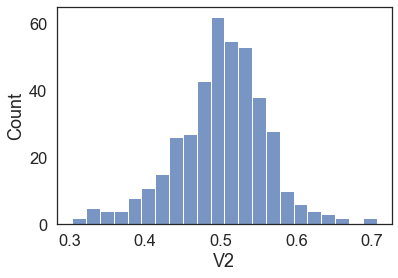

In [220]:
modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             'TCGA',
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
sns.histplot(modes['V2'])

<Axes: xlabel='V2', ylabel='Count'>

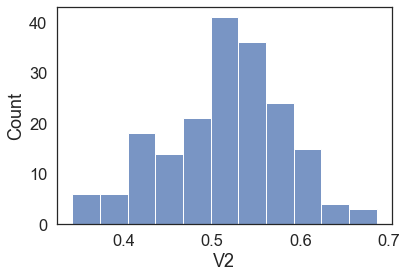

In [19]:
modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             'Ringner',
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
sns.histplot(modes['V2'])

In [23]:
clinical['Ringner']['middle_mode'] = modes['V2']

In [21]:
modes

,V1,V2,V3
GSM1941862,0.184802,0.450006,0.762204
GSM1941863,0.260572,0.457527,0.674866
GSM1941864,0.208212,0.497759,0.774748
GSM1941865,0.343519,0.558180,0.667033
GSM1941866,0.270288,0.559414,0.793674
...,...,...,...
GSM1942045,0.286699,0.559628,0.794940
GSM1942046,0.224667,0.391188,0.796051
GSM1942047,0.317243,0.577032,0.718690
GSM1942048,0.345114,0.492511,0.749177


In [28]:
(clinical['Ringner']['in_analysis_dataset'] & ~clinical['Ringner']['spfPercent'].isna()).sum()

92

In [27]:
(~clinical['Ringner']['spfPercent'].isna() & clinical['Ringner']['in_analysis_dataset'] & (clinical['Ringner']['middle_mode'] < 0.6) & (clinical['Ringner']['middle_mode'] > 0.4)).sum()

80